In [1]:
import pandas as pd
import pathlib as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import copy
import attr
import ipython_physics as phs
from typing_extensions import Self
import math
import sympy as sp
from sympy.core.symbol import Symbol
from sympy import init_printing, init_session, pprint

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@attr.define(kw_only=True)
class Qe:
    value: phs.Q = attr.field()
    err: phs.Q = attr.field()
    symbol: Symbol = attr.field(default=None)
    
    def __init__(self, value_v: float = None, err_v: float = None, unit: str = None, *, value: phs.Q = None, err: phs.Q = None, symbol: Symbol = None) -> None:
        if value is not None:
            self.value = value
        if err is not None:
            self.err = err
        if value_v is not None:
            self.value = phs.Q(value_v, unit)
        if err_v is not None:
            self.err = phs.Q(err_v, unit)
        if unit is not None:
            self.convert(unit)
        self.symbol = symbol

    def eps(self):
        return self.err / self.value
    
    def condensed_repr(self, notation: str = '.1E') -> str:
        self.convert(self.value.unit)
        return f"({self.value.value :{notation}} +- {self.err.value :{notation}}) {self.value.unit}"
    
    def full_repr(self) -> str:
        return f'{self.symbol} = {self.value} +- {self.err}'
    
    def __str__(self):
        return self.condensed_repr()
    
    def __repr__(self):
        return self.full_repr()
    
    def __neg__(self):
        return Qe(value=-self.value, err=self.err)

    def _sum(self, other: Self, sign1, sign2):
        value: phs.Q = self.value._sum(other.value, sign1, sign2)
        err: phs.Q = self.err._sum(other.err, sign1, sign2)
        return self.__class__(value=value, err=err)

    def __add__(self, other):
        return self._sum(other, 1, 1)

    __radd__ = __add__

    def __sub__(self, other):
        return self._sum(other, 1, -1)

    def __rsub__(self, other):
        return self._sum(other, -1, 1)

    def __eq__(self, other):
        diff = self._sum(other, 1, -1)
        return diff.value == 0

    def __lt__(self, other):
        diff = self._sum(other, 1, -1)
        return diff.value < 0

    def __mul__(self, other):
        if (isinstance(other, Qe)):
            other_eps = other.eps()
            value: phs.Q = self.value * other.value
        else:
            other_eps = 0
            value: phs.Q = self.value * other
        
        err: phs.Q = value * math.sqrt(self.eps() ** 2 + other_eps ** 2)
        
        return self.__class__(value=value, err=err)

    __rmul__ = __mul__

    def __div__(self, other):
        if (isinstance(other, Qe)):
            other_eps = other.eps()
            value: phs.Q = self.value / other.value
        else:
            other_eps = 0
            value: phs.Q = self.value / other

        err: phs.Q = value * math.sqrt(self.eps() ** 2 + other_eps ** 2)
            
        return self.__class__(value=value, err=err)

    __truediv__ = __div__

    def __pow__(self, other):
        value: phs.Q = pow(self.value, other)
        err: phs.Q = value * self.eps() * math.sqrt(abs(other))
        return self.__class__(value=value, err=err)

    def convert(self, unit):
        self.value.convert(unit)
        self.err.convert(unit)


In [3]:
V1 = Qe(value_v=800, err_v=5, unit='cm^3', symbol=Symbol('V_1'))
V2 = Qe(value_v=800, err_v=5, unit='cm^3', symbol=Symbol('V_2'))

LtoS = Qe(value_v=15, err_v=0.1, unit='1/cm')

In [4]:
data_set = []
data_dir = pl.Path.cwd().parent / "data" / "csv_files"

data_set = np.array(
    [
        [float(file.name.split(".")[0]), pd.read_csv(file)]
        for file in data_dir.iterdir()
        if file.name.endswith(".csv")
    ],
    dtype=object
)

pressure_values = np.array(list(data_set[0:,0:1].flatten()))

FileNotFoundError: [Errno 2] No such file or directory: '/home/andrew/MEGA/mipt/courses/labs/mipt_physics_labs/2.3.1/Andrew/data/csv_files'

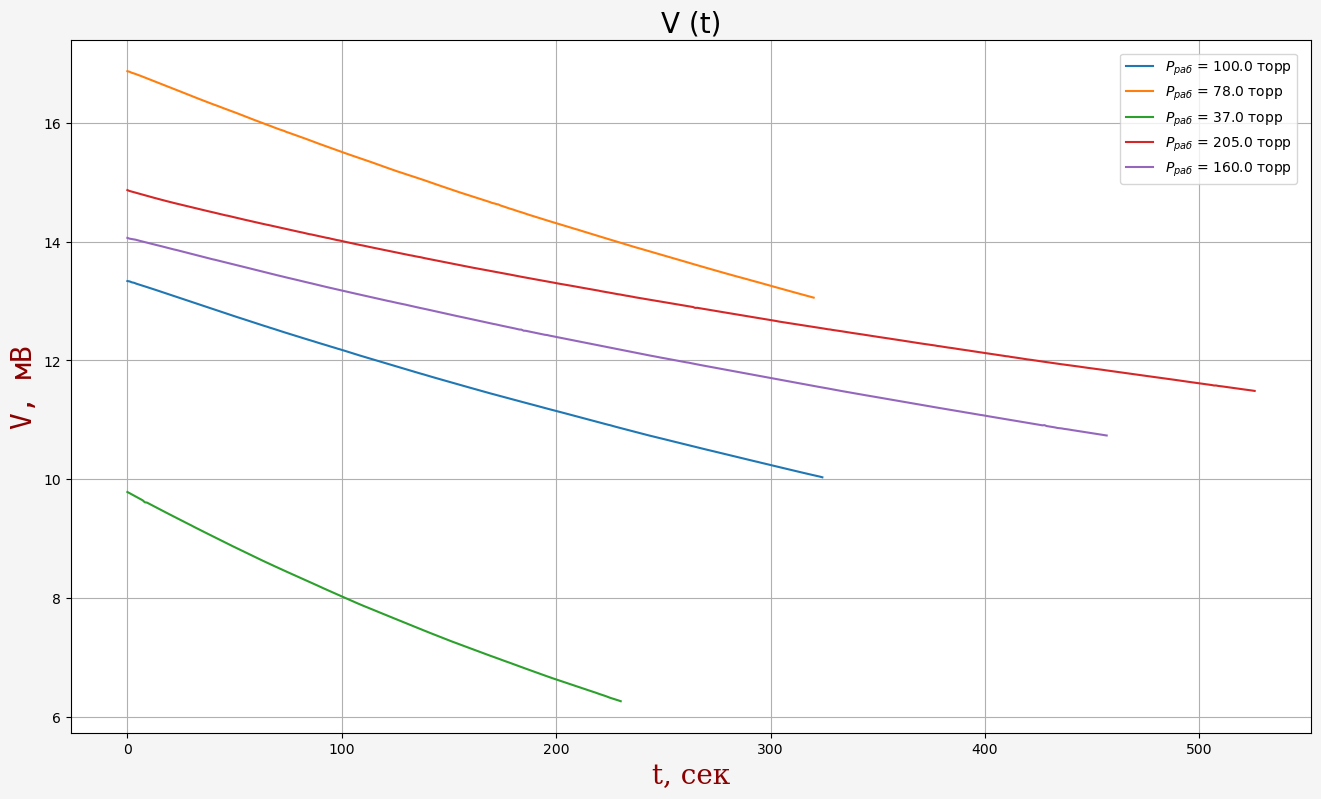

In [ ]:
# V(t)

fig = plt.figure(
    figsize=(16, 9),  # размером 16 на 9 дюймов
    facecolor='whitesmoke',  # c подложкой цвета белый дым
    dpi=100  # разрешением 200 точек
)

for data in data_set:
    plt.plot(
        np.array(data[1]['t (s)']),
        np.array(data[1]['V (mV)']),
        label='$P_{раб}$ = ' + str(data[0]) + ' торр'
    )

plt.title('V (t)', fontsize=20)

plt.xlabel(
    't, сек',  # Текст
    fontdict=dict(family='serif', color='darkred', weight='normal', size=20)  # Настройки шрифта
)
plt.ylabel(
    'V, мВ',
    fontdict=dict(family='monospace', color='darkred', weight='light', size=20)
)

plt.legend(
    loc='upper right',  # Снизу слева 
    borderaxespad=1  # С отступом 5 от осей
)

plt.grid(True)

plt.show()

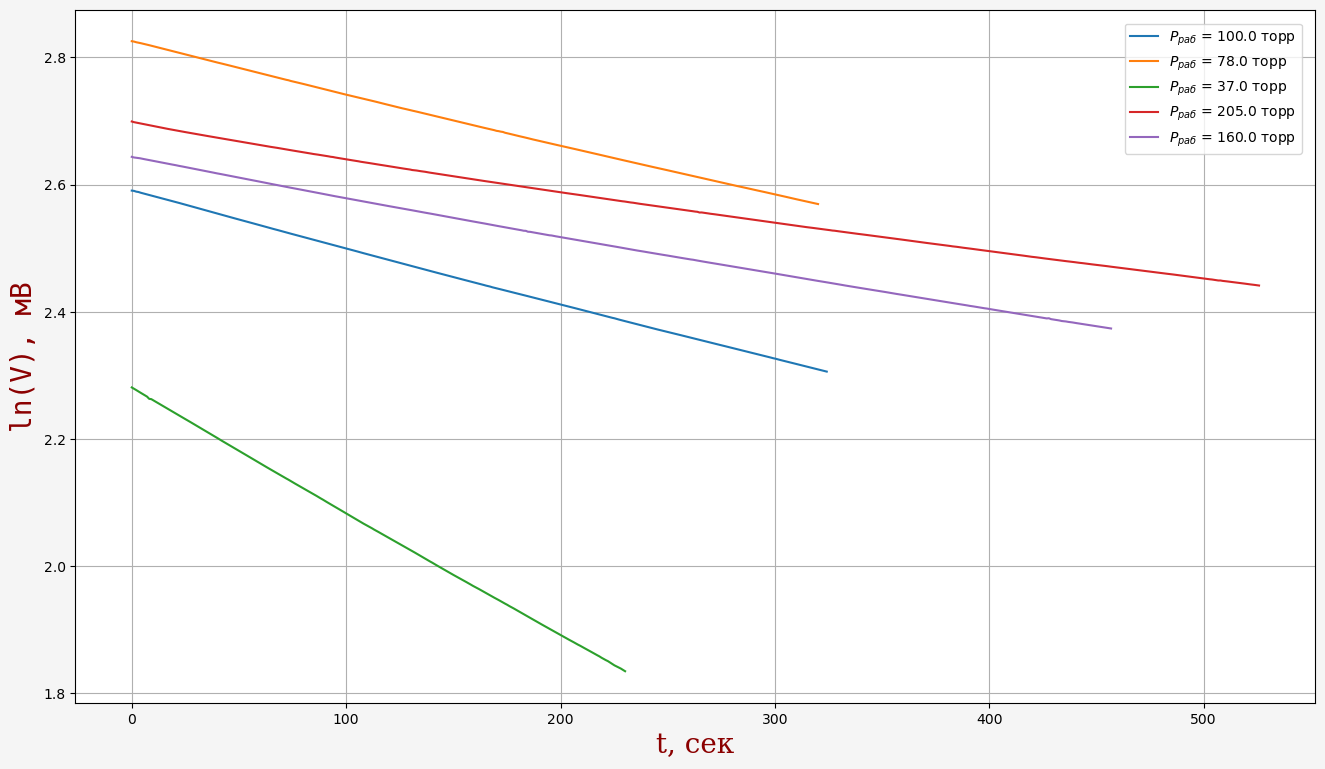

In [ ]:
# ln(V(t))

fig = plt.figure(
    figsize=(16, 9),  # размером 16 на 9 дюймов
    facecolor='whitesmoke',  # c подложкой цвета белый дым
    dpi=100  # разрешением 200 точек
)

for data in data_set:
    plt.plot(
        np.array(data[1]['t (s)']),
        np.array(np.log(data[1]['V (mV)'])),
        label='$P_{раб}$ = ' + str(data[0]) + ' торр'
    )

plt.xlabel(
    't, сек',  # Текст
    fontdict=dict(family='serif', color='darkred', weight='normal', size=20)  # Настройки шрифта
)
plt.ylabel(
    'ln(V), мВ',
    fontdict=dict(family='monospace', color='darkred', weight='light', size=20)
)

plt.legend(
    loc='upper right',  # Снизу слева 
    borderaxespad=1  # С отступом 5 от осей
)

plt.grid(True)

plt.show()

In [ ]:
# lines

lines = []

lines = list(
    [
        linregress(x=data[1]['t (s)'], y=np.log(data[1]['V (mV)']))
        for data in data_set
    ],
    # dtype=object
)

# for data in data_set:
#     lines.append((data[0], linregress(x=data[1]['t (s)'], y=np.log(data[1]['V (mV)']))))

slopes = np.array([Qe(value_v=line.slope, err_v=line.stderr, unit='1/s') for line in lines])

# D_values = np.array([-V1 * V2 / (V1 + V2) * LtoS * slope for slope in slopes])
D_values: np.ndarray[Qe] = slopes * (-V1 * V2 / (V1 + V2) * LtoS)

In [ ]:
for D in D_values:
    D.convert('cm**2/s')

In [ ]:
x = pressure_values ** -1
y = np.array([d.value.value for d in D_values])
y_err = np.array([d.err.value for d in D_values])

lineD_P = linregress(x=x, y=y)

a = Qe(value_v=lineD_P.slope, err_v=lineD_P.stderr, unit='Pa * cm**2/s')
b = Qe(value_v=lineD_P.intercept, err_v=lineD_P.intercept_stderr, unit='cm**2/s')

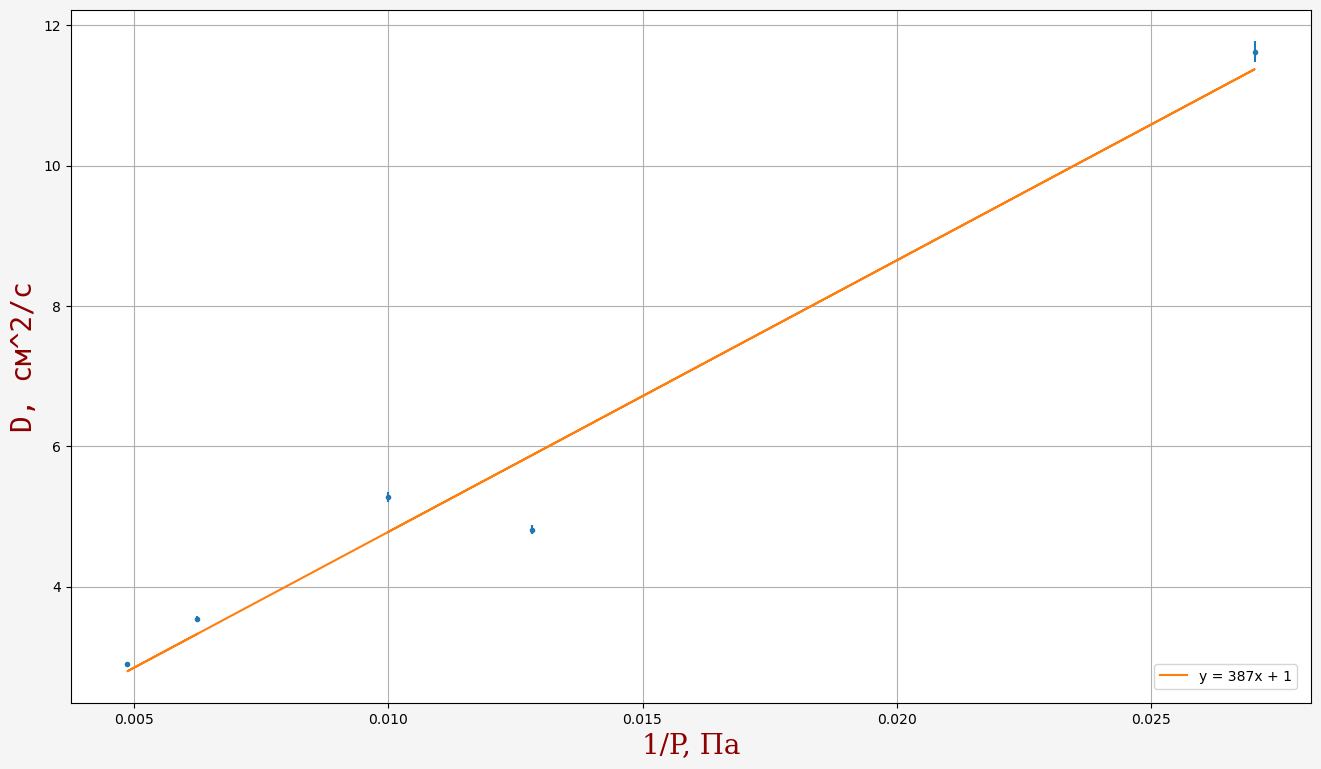

In [ ]:
# D(1/P)

fig = plt.figure(
    figsize=(16, 9),  # размером 16 на 9 дюймов
    facecolor='whitesmoke',  # c подложкой цвета белый дым
    dpi=100  # разрешением 200 точек
)

plt.errorbar(
    x=x,
    y=y,
    yerr=y_err,
    linestyle='',
    fmt='.',
)

#calculate equation for trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(
    x, p(x),
    label=f'y = {a.value.value :.0f}x + {b.value.value :.0f}'
)

lineD_P = linregress(x=x, y=y)

# plt.title('V(t)', fontsize=20)

plt.xlabel(
    '1/P, Па',  # Текст
    fontdict=dict(family='serif', color='darkred', weight='normal', size=20)  # Настройки шрифта
)
plt.ylabel(
    'D, см^2/c',
    fontdict=dict(family='monospace', color='darkred', weight='light', size=20)
)

plt.legend(
    loc='lower right',  # Снизу слева 
    borderaxespad=1  # С отступом 5 от осей
)

plt.grid(True)

plt.show()

del x, y

In [ ]:
Patm = Qe(value_v=10**5, err_v=1, unit='Pa')
D_Patm = a * 1/Patm + b
D_Patm.convert('cm**2/s')
D_Patm

None = 0.9069792947796436 cm**2/s +- 0.5794604974231924 cm**2/s

In [ ]:
table = pd.DataFrame()

P_raw_name = 'P, Па'
D_raw_name = 'D, см^2/с'
slope_raw_name = 'slope, Па * см^2 / с'

T = Qe(value_v=300, err_v=1, unit='K')
R = Qe(value_v=8.314, err_v=0, unit='J/mol/K')
mu = Qe(value_v=4, err_v=0, unit='g/mol')

# print((math.pi * mu) / (8 * R * T) ** (0.5))

# l = D_values * (3 * (math.pi * mu) / (8 * R * T) ** (0.5))

print(V1 / T / R)

table[P_raw_name] = pressure_values
table[D_raw_name] = [d.condensed_repr('.2f') for d in D_values]
table[slope_raw_name] = [d.condensed_repr('.7f') for d in slopes]

table.sort_values(P_raw_name)


(3.2E-01 +- 2.3E-03) cm**3*mol/J


,"P, Па","D, см^2/с","slope, Па * см^2 / с"
2,37.0,(11.63 +- 0.15) cm**2/s,(-0.0019377 +- 0.0000013) 1/s
1,78.0,(4.81 +- 0.06) cm**2/s,(-0.0008017 +- 0.0000009) 1/s
0,100.0,(5.28 +- 0.07) cm**2/s,(-0.0008799 +- 0.0000008) 1/s
4,160.0,(3.54 +- 0.05) cm**2/s,(-0.0005893 +- 0.0000009) 1/s
3,205.0,(2.89 +- 0.04) cm**2/s,(-0.0004816 +- 0.0000011) 1/s
